# Reinforcement Learning Group Project

Author: Kim Isabella Zierahn, 6635183


This notebook documents my contributions and code to the group project. It contains checkpoints, thoughts, code snippets, where I tried out things, and plots.


## Checkpoint 1: Get your algorithms up and running

I am comparing three PPO models that get increasingly optimized. The performance is tested on simple environments to determine the best working algorithm out of the three. For continous actions, I am using the Pendulum and HalfCheetah from the OpenAI Gym.

In [1]:
import gymnasium as gym
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
import hockey.hockey_env as h_env
from hockey.hockey_env import Mode

### Continuous Action Space: Pendulum

In [2]:
env_pend = gym.make("Pendulum-v1")
state_dim = env_pend.observation_space.shape[0]
action_dim = env_pend.action_space.shape[0]

#### Vanilla PPO

This is the standard unmodified **vanilla PPO** algorithm that I take as a base comparison.

**Source:** The basis of this PPO base algorithm comes from: University of Tübingen, Autonomous Learning, Reinforcement Learning Lecture 8: "PPO_08_solution.py"

In [3]:
from PPO import PPO, Memory

ppo_vanilla = PPO(
    state_dim,
    action_dim,
    n_latent_var = 128,
    lr = 0.003,
    betas = (0.9, 0.999),
    gamma = 0.99,
    K_epochs = 10,
    eps_clip = 0.25,
    has_continuous_action_space = True,
    action_std_init = 0.5
)

# ppo_vanilla = PPO(
#     state_dim,
#     action_dim,
#     n_latent_var = 64,
#     lr = 0.002,
#     betas = (0.9, 0.999),
#     gamma = 0.99,
#     K_epochs = 10,
#     eps_clip = 0.2,
#     has_continuous_action_space = False,
#     action_std_init = 0.6
# )


#### PPG

This is a **PPG** algorithm, a modified version of PPO. It consists of two training phases: a policy phase and an additional **periodic auxiliary phase**. During the policy phase, we are training the agent with vanilla PPO, optimizing the clipped surrogate objective. During the auxiliary phase, we distill features from the value function into the policy network

In [4]:
from PPG_final import PPO
ppg = PPO(
    state_dim,
    action_dim,
    n_latent_var_actor = 128,
    n_latent_var_critic = 128,
    network_depth_actor = 1,
    network_depth_critic = 1,
    has_continuous_action_space = True,
    action_std_init = 0.5,
    lr = 0.003,
    betas = (0.9, 0.999),
    gamma = 0.99,
    K_epochs = 10,
    eps_clip = 0.25,
    c1 = 0.5,
    c2 = 0.01,
    beta_clone = 0.95
)

#### PPG with Beta distribution and Initialization

This is a PPG algorithm with **Beta distribution** and improved **Initialization**. It is an optimized version of PPG, where we are using a Beta distribution for the action space and initializing the weights of the policy network with the weights of the value network.

In [5]:
from PPG_GAE import PPO, Memory

ppg_GAE = PPO(
    state_dim,
    action_dim,
    n_latent_var_actor = 128,
    n_latent_var_critic = 128,
    network_depth_actor = 1,
    network_depth_critic = 1,
    has_continuous_action_space = True,
    action_std_init = 0.5,
    lr = 0.003,
    betas = (0.9, 0.999),
    gamma = 0.99,
    K_epochs = 10,
    eps_clip = 0.25,
    c1 = 0.5,
    c2 = 0.01,
    beta_clone = 0.95
)

In [6]:
from PPG_GAE_KL import PPO

ppg_KL = PPO(
    state_dim,
    action_dim,
    n_latent_var_actor = 128,
    n_latent_var_critic = 128,
    network_depth_actor = 1,
    network_depth_critic = 1,
    has_continuous_action_space = True,
    action_std_init = 0.5,
    lr = 0.003,
    betas = (0.9, 0.999),
    gamma = 0.99,
    K_epochs = 10,
    eps_clip = 0.25,
    c1 = 0.5,
    c2 = 0.01,
    beta_clone = 0.95
)

#### Comparison of Training Behavior

In [8]:
# Training loop
def train_pendulum_ppo(env, max_episodes, max_timesteps, update_timestep, agent):
    memory = Memory()
    timestep = 0
    episode_rewards = []

    print("Agent: ", agent)

    for episode in range(max_episodes):
        state, _ = env.reset()
        state = state.flatten()
        episode_reward = 0

        for t in range(max_timesteps):
            timestep += 1

            # Sample action
            action = agent.policy_old.act(state, memory)
            state, reward, done, _, _ = env.step(action)
            state = state.flatten()

            # Save reward and terminal state
            memory.rewards.append(reward)
            memory.is_terminals.append(done)

            episode_reward += reward

            if done:
                break

        # Update PPO if it's time
        if timestep % update_timestep == 0:
            agent.update(memory)
            memory.clear_memory()
            timestep = 0

        if episode % 50 == 0:
            print(f"Episode {episode + 1}, Reward: {episode_reward}")

        episode_rewards.append(episode_reward)
        # print(f"Episode {episode + 1}, Reward: {episode_reward}")

    return episode_rewards

In [20]:
# Training loop
def train_pendulum_ppg(env, max_episodes, max_timesteps, update_timestep, agent):
    memory = Memory()
    timestep = 0
    episode_rewards = []

    print("Agent: ", agent)

    for episode in range(max_episodes):
        state, _ = env.reset()
        state = state.flatten()
        episode_reward = 0

        for t in range(max_timesteps):
            timestep += 1

            # Sample action
            action = agent.policy_old.act(state, memory)
            state, reward, done, _, _ = env.step(action)
            state = state.flatten()

            # Save reward and terminal state
            memory.rewards.append(reward)
            memory.is_terminals.append(done)

            episode_reward += reward

            if done:
                break

        # Update PPO if it's time
        if timestep % update_timestep == 0:
            agent.update(memory)
            memory.clear_memory()
            timestep = 0

        # Auxiliary phase
        if episode % 50 == 0:
            agent.auxiliary_phase(memory)
            print(f"Episode {episode + 1}, Reward: {episode_reward}")

        episode_rewards.append(episode_reward)
        # print(f"Episode {episode + 1}, Reward: {episode_reward}")

    return episode_rewards

In [21]:
# Train each model for 1000 episodes
max_eps = 751
max_tsteps = 500
upd_tsteps = 100

# rewards_vanilla_ppo = train_pendulum_ppo(env_pend, max_eps, max_tsteps, upd_tsteps, ppo_vanilla)
# rewards_ppg = train_pendulum_ppg(env_pend, max_eps, max_tsteps, upd_tsteps, ppg)
# rewards_ppg_imp = train_pendulum_ppg(env_pend, max_eps, max_tsteps, upd_tsteps, ppg_init)
rewards_ppg_gae = train_pendulum_ppg(env_pend, max_eps, max_tsteps, upd_tsteps, ppg_GAE)
rewards_ppg_kl = train_pendulum_ppg(env_pend, max_eps, max_tsteps, upd_tsteps, ppg_KL)

Agent:  <PPG_GAE.PPO object at 0x126f82950>


RuntimeError: stack expects a non-empty TensorList

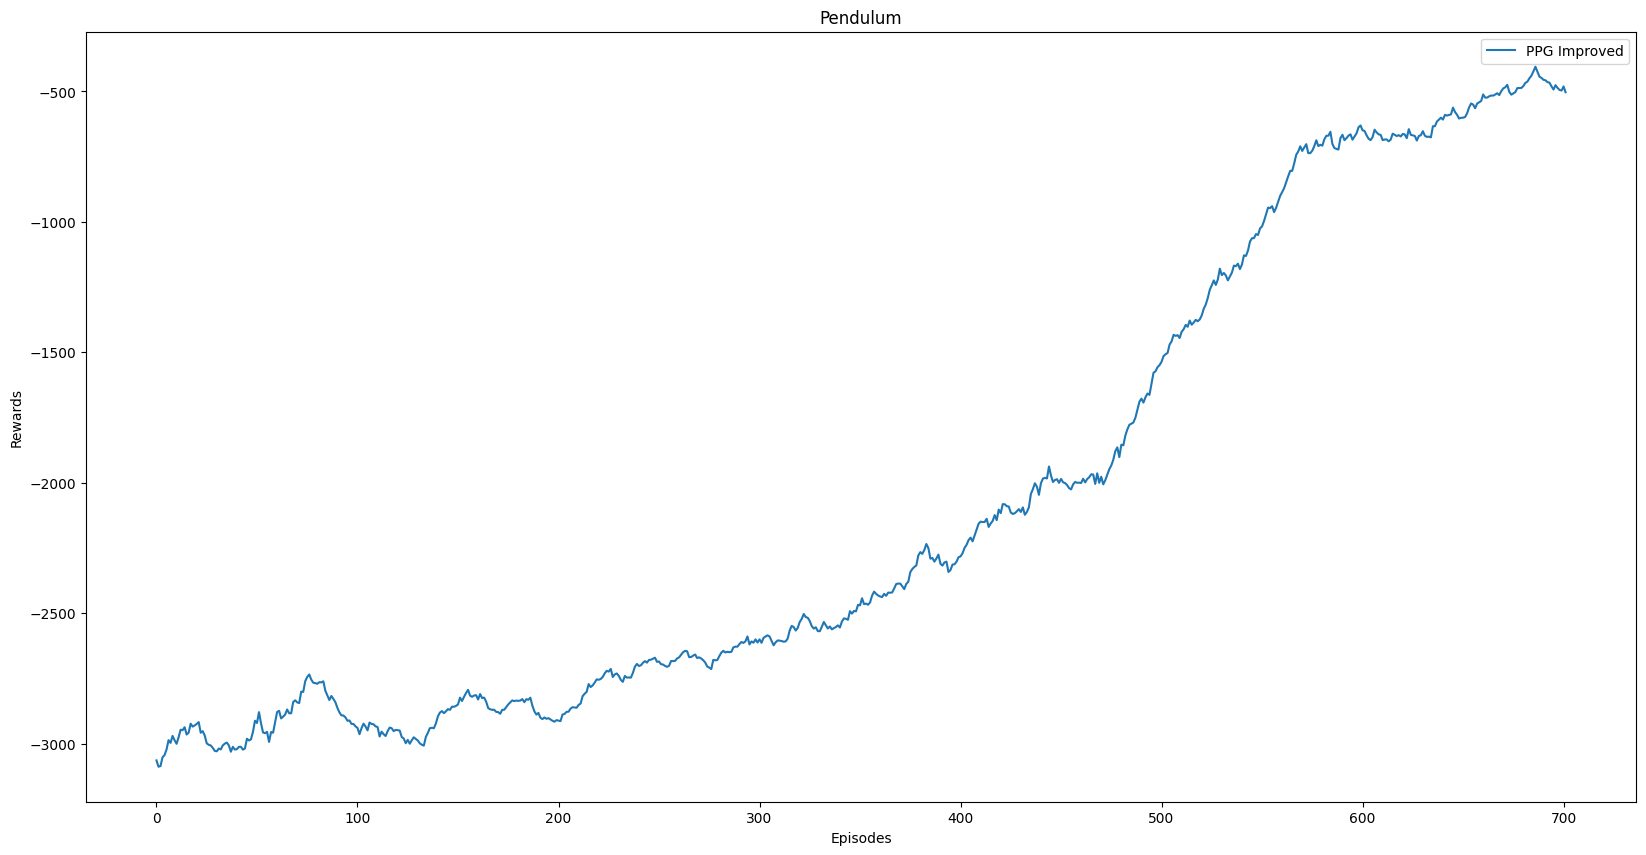

In [9]:
# Plot results
def moving_average(data, window_size):
    """Compute the moving average of a list."""
    return np.convolve(data, np.ones(window_size) / window_size, mode = "valid")

wind_size = 50

plt.figure(figsize = (20, 10))
plt.plot(moving_average(rewards_vanilla_ppo, wind_size), label = "PPO Vanilla")
# plt.plot(moving_average(rewards_ppg, wind_size), label = "PPG")
plt.plot(moving_average(rewards_ppg_gae, wind_size), label = "PPG GAE")
plt.plot(moving_average(rewards_ppg_kl, wind_size), label = "PPG KL")
# plt.plot(moving_average(rewards_ppg_imp, wind_size), label = "PPG Improved")
plt.legend()
plt.title("Pendulum")
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.show()

### Continuous Action Space: HalfCheetah

In [13]:
env_cheetah = gym.make("HalfCheetah-v5")
state_dim = env_cheetah.observation_space.shape[0]
action_dim = env_cheetah.action_space.shape[0]

DependencyNotInstalled: MuJoCo is not installed, run `pip install "gymnasium[mujoco]"`

#### Comparison of Training Behavior

In [ ]:
max_eps = 1000
max_tsteps = 500
upd_tsteps = 2000

rewards_vanilla_ppo = train_pendulum_ppo(env_pend, max_eps, max_tsteps, upd_tsteps, ppo_vanilla)
rewards_ppg = train_pendulum_ppg(env_pend, max_eps, max_tsteps, upd_tsteps, ppg)
rewards_ppg_imp = train_pendulum_ppg(env_pend, max_eps, max_tsteps, upd_tsteps, ppg_imp)

Episode 1, Reward: -4258.106915632934
Episode 51, Reward: -2796.9773874674547
Episode 101, Reward: -2175.0345401233044
Episode 151, Reward: -2429.1157414338572
Episode 201, Reward: -2427.094750291976
Episode 251, Reward: -2410.39777734524
Episode 301, Reward: -2322.258623449538
Episode 351, Reward: -2326.4278888868635
Episode 401, Reward: -2160.612332755917
Episode 451, Reward: -2521.7523128000885
Episode 501, Reward: -2403.2559874743156
Episode 551, Reward: -2860.0838697017834
Episode 601, Reward: -2444.9377002746724
Episode 651, Reward: -2813.884822208663
Episode 701, Reward: -2692.037654781878
Episode 751, Reward: -2455.5343190114436
Episode 801, Reward: -2314.7421259743983


In [ ]:
wind_size = 50

plt.figure(figsize = (20, 10))
plt.plot(moving_average(rewards_vanilla_ppo, wind_size), label = "PPO Vanilla")
plt.plot(moving_average(rewards_ppg, wind_size), label = "PPG")
plt.plot(moving_average(rewards_ppg_imp, wind_size), label = "PPG Improved")
plt.legend()
plt.title("Pendulum")
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.show()

Based on these performances, we choose the **PPG Improved** algorithm for the hockey environment as the final model.

## Checkpoint 2: Hockey – learning to handle the puck

In this part, before training my final agent on the cluster, I am trying to see a sensible training behavior, i.e. the reward should increase over time and I am checking the proportion of games I won. I am using the basic opponent for this purpose.

In [9]:
env_hockey = h_env.HockeyEnv_BasicOpponent(mode = Mode.NORMAL, weak_opponent = False)
state_dim = env_hockey.observation_space.shape[0]
action_dim = env_hockey.action_space.shape[0]

#### FINAL MODEL: PPG with Beta distribution and Initialization

In [10]:
from PPG_GAE_KL import PPO

ppg_KL = PPO(
    state_dim,
    action_dim,
    n_latent_var_actor = 128,
    n_latent_var_critic = 128,
    network_depth_actor = 1,
    network_depth_critic = 1,
    has_continuous_action_space = True,
    action_std_init = 0.5,
    lr = 0.003,
    betas = (0.9, 0.999),
    gamma = 0.99,
    K_epochs = 10,
    eps_clip = 0.25,
    c1 = 0.5,
    c2 = 0.01,
    beta_clone = 0.95
)

In [11]:
def train_hockey_ppg(env, max_episodes, max_timesteps, update_timestep, aux_phase_freq, agent):
    memory = Memory()
    episode_rewards = []
    info_list = []

    for episode in range(max_episodes):
        state, _ = env.reset()
        state = state.flatten()
        done = False
        episode_reward = 0

        # Randomly choose weak or strong opponent
        env = h_env.HockeyEnv(mode = Mode.NORMAL)
        o, info = env.reset()
        mode_random = random.choice([True, False])
        player2 = h_env.BasicOpponent(weak = mode_random)
        obs_agent2 = env.obs_agent_two()

        for t in range(max_timesteps):
            action = agent.policy_old.act(state, memory)

            action_opp = player2.act(obs_agent2)

            next_state, reward, done, _, info = env.step(np.hstack([action, action_opp]))
            next_state = next_state.flatten()

            memory.rewards.append(reward)
            memory.is_terminals.append(done)

            episode_reward += reward
            state = next_state

            obs_agent2 = env.obs_agent_two()

            if done:
                break

        # Auxiliary phase: Train value function
        if episode % aux_phase_freq == 0:
            agent.auxiliary_phase(memory)

        # Update PPO
        if episode % update_timestep == 0:
            agent.update(memory)
            memory.clear_memory()

        # Log episode results
        episode_rewards.append(episode_reward)
        info_list.append(info.get("winner", None))
        print(f"Episode {episode + 1}, Reward: {episode_reward}")

        # if episode % checkpoint_freq == 0:
        #     ppo_agent.save_checkpoint(checkpoint_dir, episode)

    return episode_rewards, info_list, agent

In [14]:
# Train model for 1000 episodes
max_eps = 1000
max_tsteps = 500
upd_tsteps = 500
aux_phase = 50

rewards_ppg_imp, info_ppg_imp, ppo_imp = train_hockey_ppg(env_hockey, max_eps, max_tsteps, upd_tsteps, aux_phase, ppg_KL)

Episode 1, Reward: -12.283654165446796
Episode 2, Reward: -11.696670551836572
Episode 3, Reward: -13.130336128819163
Episode 4, Reward: -11.87546182568461
Episode 5, Reward: -25.089442024549584
Episode 6, Reward: -13.877759887817078
Episode 7, Reward: -11.976001001719165
Episode 8, Reward: -18.589338136011563
Episode 9, Reward: -6.855189208545833
Episode 10, Reward: -11.52760224938458
Episode 11, Reward: -8.516115277601047
Episode 12, Reward: -41.75849924314839
Episode 13, Reward: -12.252790149243465
Episode 14, Reward: -11.730625038416244
Episode 15, Reward: -21.65211568368728
Episode 16, Reward: 6.8483208567166445
Episode 17, Reward: -12.747263720026936
Episode 18, Reward: -13.233440332065555
Episode 19, Reward: -12.047238353565632
Episode 20, Reward: 6.063423061377914
Episode 21, Reward: -11.826390563441096
Episode 22, Reward: -12.076690057697395
Episode 23, Reward: -11.853224233968504
Episode 24, Reward: -14.26009738403206
Episode 25, Reward: -11.752349466432097
Episode 26, Reward:

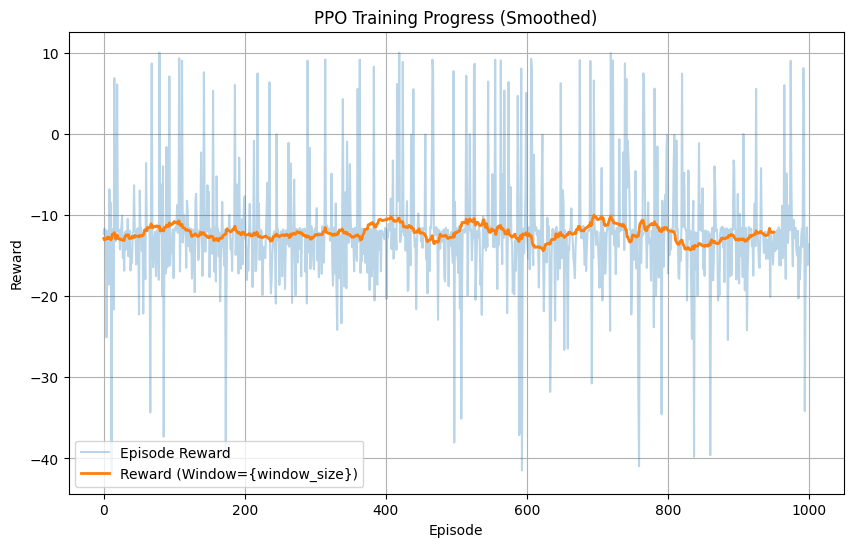

In [15]:
# Plot results
def moving_average(data, window_size):
    """Compute the moving average of a list."""
    return np.convolve(data, np.ones(window_size) / window_size, mode = "valid")

wind_size = 50

plt.figure(figsize = (10, 6))
plt.plot(rewards_ppg_imp, label = "Episode Reward", alpha = 0.3)
plt.plot(moving_average(rewards_ppg_imp, wind_size),  label = "Reward (Window={window_size})", linewidth = 2)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("PPO Training Progress (Smoothed)")
plt.legend()
plt.grid()
plt.show()

Win rate: 0.055, Loss rate: 0.055, Tie rate: 0.211


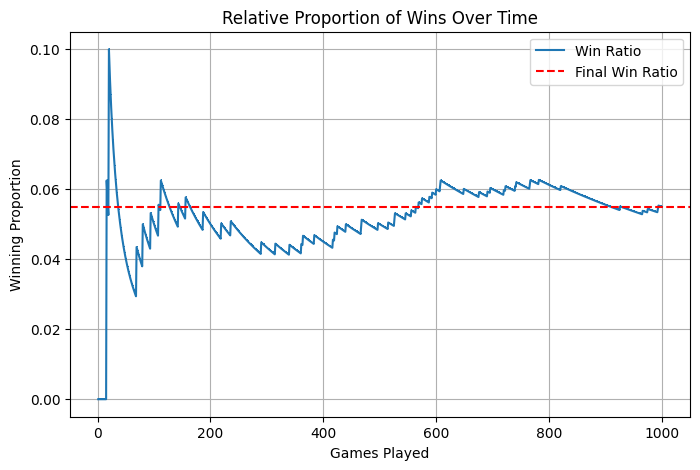

In [16]:
# Plot win rate

# calculate the number of 0,-1, 1 for each episode and divide by the number of episodes
num_episodes = len(info_ppg_imp)

num_ties = np.sum(np.array(info_ppg_imp) == 0)
num_wins = np.sum(np.array(info_ppg_imp) == 1)
num_losses = np.sum(np.array(info_ppg_imp) == -1)

ratio_ties = round(num_ties / num_episodes, 3)
ratio_wins = round(num_wins/ num_episodes, 3)
ratio_losses = round(num_wins / num_episodes, 3)

print(f"Win rate: {ratio_wins}, Loss rate: {ratio_losses}, Tie rate: {ratio_ties}")

info_array = np.array(info_ppg_imp)
games_played = np.arange(1, len(info_ppg_imp) + 1)
wins = np.cumsum(info_array == 1)
win_ratio = wins / games_played

plt.figure(figsize = (8, 5))
plt.plot(games_played, win_ratio, marker = ',', linestyle = '-', label = "Win Ratio")
plt.axhline(y = ratio_wins, color = 'r', linestyle = '--', label = "Final Win Ratio")
plt.xlabel("Games Played")
plt.ylabel("Winning Proportion")
plt.title("Relative Proportion of Wins Over Time")
plt.legend()
plt.grid(True)
plt.show()